# Traits prediction in Tsetse flies uisng restirctied number of wavenumbers
Final jupyter notebook for sex, and age prediction of males and females flies using the infrared region from 1750-602 cm-1. This notebooks creates the models and reproduces figure 5 and figure S3 of the manuscript. 

## Changelog
### 16/11/2023
Added extraction of top20 wavenumbers plot

In [2]:
%load_ext autoreload
%autoreload 2

In [71]:
# import packages

import sys

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import joblib


from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import model_optimization
from utilities import train_model
from utilities import test_model
from utilities import variable_importance_df
from utilities import add_label_band
from utilities import montecarlo_crossvalidation

In [4]:
colors = sn.color_palette("Set2") 

In [5]:
tsetse_data = pd.read_csv("../data/processed/TseTse_processed.csv")

In [7]:
df_ic = pd.DataFrame(tsetse_data.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue      
f   3d  Abdomen   48
        Head     133
        Thorax   136
    5w  Abdomen   16
        Head      92
        Thorax    96
    7w  Abdomen   38
        Head     120
        Thorax   122
m   5w  Head      94
        Thorax    93
    7w  Abdomen   15
        Head      93
        Thorax    92

In [6]:
tsetse_data_sameages = tsetse_data[(tsetse_data["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

tsetse_thorax = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Head']

## Sex prediction

In [7]:
X_sex_thorax = tsetse_thorax.loc[:,"1750":"602"]
y_sex_thorax = tsetse_thorax.loc[:,"Sex"]

X_sex_head = tsetse_head.loc[:,"1750":"602"]
y_sex_head = tsetse_head.loc[:,"Sex"]

In [33]:
waveNumslist = X_sex_thorax.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [8]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_sex_thorax, y_sex_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_sex_head, y_sex_head, test_size=0.2, shuffle=True, random_state=123)

In [10]:
sex_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
sex_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [11]:
sex_data_plot_thorax = dataplotmelt(sex_thorax_acc_baseline)
sex_data_plot_head = dataplotmelt(sex_head_acc_baseline)

In [81]:
# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [80]:
# Train the best model
sex_model_head=train_model(X_hd_train,y_hd_train, best_model_head,'sex_head_informative')
sex_model_thorax=train_model(X_th_train,y_th_train, best_mdoel_thorax,'sex_thorax_informative')

In [9]:
#test model
loaded_model_sex_head = joblib.load('../results/models/trained_model_sex_head_informative.sav')
loaded_model_sex_thorax = joblib.load('../results/models/trained_model_sex_thorax_informative.sav')

In [10]:
y_sex_head_pred, y_sex_head_prob = test_model(X_hd_test, y_hd_test, loaded_model_sex_head)

y_sex_thorax_pred, y_sex_thorax_prob = test_model(X_th_test, y_th_test, loaded_model_sex_thorax)

Accuracy on test set using the head: 0.9625
Accuracy on test set using the head: 0.9012345679012346


## Male age prediction

In [11]:
tsetse_males_thorax = tsetse_data.loc[(tsetse_data['Sex'] == 'm') & (tsetse_data['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data.loc[(tsetse_data['Sex'] == 'm') & (tsetse_data['Tissue'] == 'Head')]

In [12]:
X_males_thorax = tsetse_males_thorax.loc[:,"1750":"602"]
X_males_head = tsetse_males_head.loc[:,"1750":"602"]

y_males_thorax = tsetse_males_thorax.loc[:,"Age"]
y_males_head = tsetse_males_head.loc[:,"Age"]

In [13]:
Xm_th_train, Xm_th_test, ym_th_train, ym_th_test = train_test_split(X_males_thorax, y_males_thorax, test_size=0.2, shuffle=True, random_state=123)

Xm_hd_train, Xm_hd_test, ym_hd_train, ym_hd_test = train_test_split(X_males_head, y_males_head, test_size=0.2, shuffle=True, random_state=123)

In [16]:
males_thorax_acc_baseline = baseline_accuracy(Xm_th_train, ym_th_train)
males_head_acc_baseline = baseline_accuracy(Xm_hd_train,ym_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [17]:
males_data_plot_thorax = dataplotmelt(males_thorax_acc_baseline)
males_data_plot_head = dataplotmelt(males_head_acc_baseline)

In [77]:
# model optimization

males_best_model_head = model_optimization(Xm_hd_train,ym_hd_train)
males_best_model_thorax = model_optimization(Xm_th_train, ym_th_train)

Best model parameters{'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [88]:
# Train the best model
train_model(Xm_hd_train,ym_hd_train, males_best_model_head,"head_male_informative")
train_model(Xm_th_train,ym_th_train,males_best_model_thorax,"thorax_male_informative")

In [14]:
#test model
loaded_model_males_head = joblib.load('../results/models/trained_model_head_male_informative.sav')

loaded_model_males_thorax = joblib.load('../results/models/trained_model_thorax_male_informative.sav')

In [15]:
y_male_head_pred, y_male_head_prob = test_model(Xm_hd_test, ym_hd_test, loaded_model_males_head)

y_male_thorax_pred, y_male_thorax_prob = test_model(Xm_th_test, ym_th_test, loaded_model_males_thorax)

Accuracy on test set using the head: 0.9473684210526315
Accuracy on test set using the head: 0.8648648648648649


## Female age prediction

In [16]:
tsetse_females_thorax = tsetse_data.loc[(tsetse_data['Sex'] == 'f') & (tsetse_data['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data.loc[(tsetse_data['Sex'] == 'f') & (tsetse_data['Tissue'] == 'Head')]

In [17]:
X_females_thorax = tsetse_females_thorax.loc[:,"1750":"602"]
X_females_head = tsetse_females_head.loc[:,"1750":"602"]

y_females_thorax = tsetse_females_thorax.loc[:,"Age"]
y_females_head = tsetse_females_head.loc[:,"Age"]

In [18]:
Xf_th_train, Xf_th_test, yf_th_train, yf_th_test = train_test_split(X_females_thorax, y_females_thorax, test_size=0.2, shuffle=True, random_state=123)

Xf_hd_train, Xf_hd_test, yf_hd_train, yf_hd_test = train_test_split(X_females_head, y_females_head, test_size=0.2, shuffle=True, random_state=123)

In [23]:
females_thorax_acc_baseline = baseline_accuracy(Xf_th_train, yf_th_train)
females_head_acc_baseline = baseline_accuracy(Xf_hd_train,yf_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [24]:
females_data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
females_data_plot_head = dataplotmelt(females_head_acc_baseline)

In [96]:
# model optimization

females_best_model_head = model_optimization(Xf_hd_train,yf_hd_train)
females_best_model_thorax = model_optimization(Xf_th_train, yf_th_train)

Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [25]:
# Train the best model
train_model(Xf_hd_train,yf_hd_train, females_best_model_head,"head_female_informative")
train_model(Xf_th_train,yf_th_train, females_best_model_thorax,"thorax_female_informative")

NameError: name 'females_best_model_head' is not defined

In [19]:
#test model
loaded_model_females_head = joblib.load('../results/models/trained_model_head_female_informative.sav')

loaded_model_females_thorax = joblib.load('../results/models/trained_model_thorax_female_informative.sav')

In [20]:
y_female_head_pred, y_female_head_prob = test_model(Xf_hd_test, yf_hd_test, loaded_model_females_head)

y_female_thorax_pred, y_female_thorax_prob = test_model(Xf_th_test, yf_th_test, loaded_model_females_thorax)

Accuracy on test set using the head: 0.8260869565217391
Accuracy on test set using the head: 0.8732394366197183


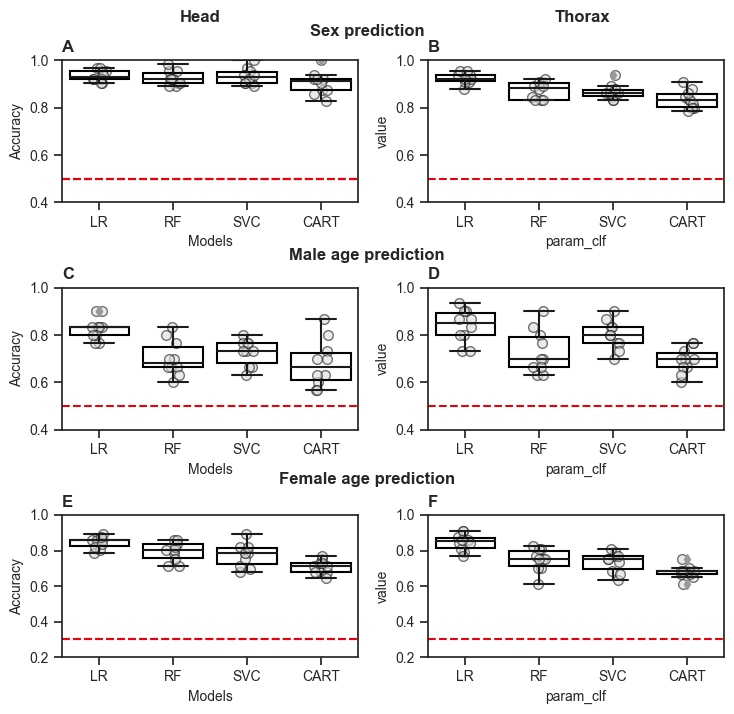

In [28]:
# Figure 4

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":10,
    'xtick.labelsize':10,
    'ytick.labelsize':10}

sn.set_style("ticks")
sn.set_context('notebook', rc=rc)
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(7.5,7), tight_layout=False)

plt.subplots_adjust(hspace=0)


# Sex prediction
sn.boxplot(data=sex_data_plot_head, x='param_clf',y='value',ax=ax, color='white',boxprops={'fill': None})
sn.stripplot(data=sex_data_plot_head, x='param_clf',y='value',ax=ax,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax.lines, color='k')

for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)


sn.boxplot(data=sex_data_plot_thorax, x='param_clf',y='value',ax=ax2, color='white',boxprops={'fill': None})
sn.stripplot(data=sex_data_plot_thorax, x='param_clf',y='value',ax=ax2,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax2.lines, color='k')

for l, box in enumerate(ax2.patches):
    box.set_edgecolor('black')

ax2.axhline(0.5, color='r', ls='--')
ax2.set_ylim(0.4,1)





# Male age prediction
sn.boxplot(data=males_data_plot_thorax, x='param_clf',y='value',ax=ax4, color='white',boxprops={'fill': None})
sn.stripplot(data=males_data_plot_thorax, x='param_clf',y='value',ax=ax4,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax4.lines, color='k')
for l, box in enumerate(ax4.patches):
    box.set_edgecolor('black')

ax4.axhline(0.5, color='r', ls='--')
ax4.set_ylim(0.4,1)


sn.boxplot(data=males_data_plot_head, x='param_clf',y='value',ax=ax3, color='white',boxprops={'fill': None})
sn.stripplot(data=males_data_plot_head, x='param_clf',y='value',ax=ax3,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax3.lines, color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)




# female age prediction
sn.boxplot(data=females_data_plot_head, x='param_clf',y='value',ax=ax5, color='white',boxprops={'fill': None})
sn.stripplot(data=females_data_plot_head, x='param_clf',y='value',ax=ax5,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax5.lines, color='k')
for l, box in enumerate(ax5.patches):
    box.set_edgecolor('black')

ax5.axhline(0.3, color='r', ls='--')
ax5.set_ylim(0.2,1)

sn.boxplot(data=females_data_plot_thorax, x='param_clf',y='value',ax=ax6, color='white',boxprops={'fill': None})
sn.stripplot(data=females_data_plot_thorax, x='param_clf',y='value',ax=ax6,size=7,linewidth=1,edgecolor='k',color='gainsboro',zorder=0, alpha=0.6, legend=False)
plt.setp(ax6.lines, color='k')
for l, box in enumerate(ax6.patches):
    box.set_edgecolor('black')

ax6.axhline(0.3, color='r', ls='--')
ax6.set_ylim(0.2,1)






# Overall aesthetics and annotations

plots1 = [ax2,ax4,ax6]

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")



plots2 = [ax,ax3]
for i in plots2:
    i.axhline(0.5, color='r', ls='--')
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

ax5.axhline(0.3, color='r', ls='--')
ax5.set_ylim(0.2,1)
ax5.set_xlabel("Models")
ax5.set_ylabel("Accuracy")

fig.text(x=0.25,y=1,s="Head",fontweight='bold')
fig.text(x=0.75,y=1,s="Thorax",fontweight='bold')
fig.text(x=0.5,y=0.98,s="Sex prediction",ha='center',fontweight='bold')
fig.text(x=0.5,y=0.66,s="Male age prediction",ha='center',fontweight='bold')
fig.text(x=0.5,y=0.34,s="Female age prediction",ha='center',fontweight='bold')



plt.savefig("../results/plots/FigS2.tiff", dpi=300, bbox_inches='tight')

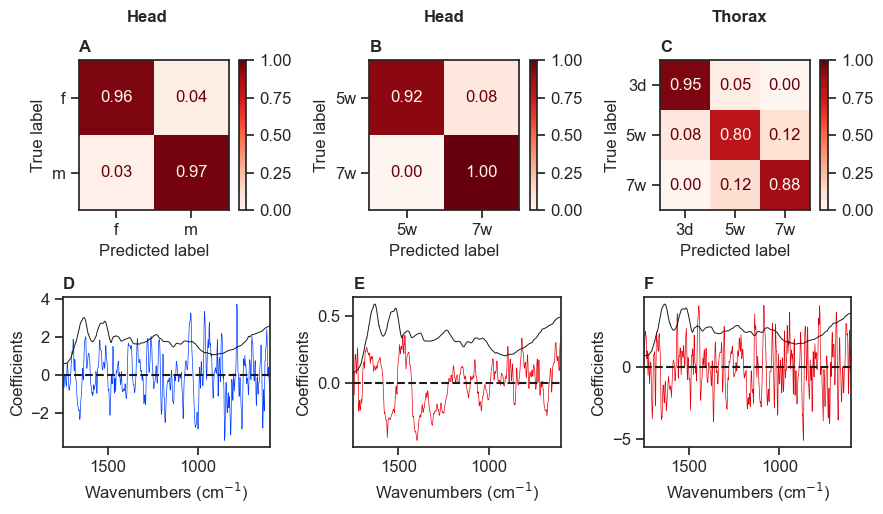

In [115]:
# plot fig5
# Final plot paper
# confusion matrix for head and model coefficients

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )
fig, ((ax, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5), tight_layout=False)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_sex_head_pred,display_labels=loaded_model_sex_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers,y=loaded_model_sex_head['model'].coef_[0], color='b',ax=ax4, linewidth=0.5)

sn.lineplot(x=wavenumbers, y=(np.mean(X_sex_head ,axis=0)*10),color='k',ax=ax4, linewidth=0.7)

#ax4.set_ylim(-3,4)


# males
disp = ConfusionMatrixDisplay.from_predictions(ym_hd_test,y_male_head_pred,display_labels=loaded_model_males_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_males_head['model'].coef_[0], color='r',ax=ax5, linewidth=0.5)
sn.lineplot(x=wavenumbers, y=(np.mean(X_males_head ,axis=0)*2),color='k',ax=ax5, linewidth=0.7)


# females
disp = ConfusionMatrixDisplay.from_predictions(yf_th_test,y_female_thorax_pred,display_labels=loaded_model_females_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax3, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_females_thorax['model'].coef_[0], color='r',ax=ax6, linewidth=0.5)
sn.lineplot(x=wavenumbers, y=(np.mean(X_females_thorax ,axis=0)*15),color='k',ax=ax6, linewidth=0.7)


plots = [ax4,ax5,ax6]
for i in plots:
    i.set_xlim(1750,600)
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")
    i.set_ylabel("Coefficients")
    i.axhline(0, ls="--",color='k')

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")

fig.text(x=0.15,y=1,s="Head",fontweight='bold')
fig.text(x=0.48,y=1,s="Head",fontweight='bold')
fig.text(x=0.8,y=1,s="Thorax",fontweight='bold')

plt.savefig("../results/plots/Fig5.tiff", dpi=300,bbox_inches='tight')


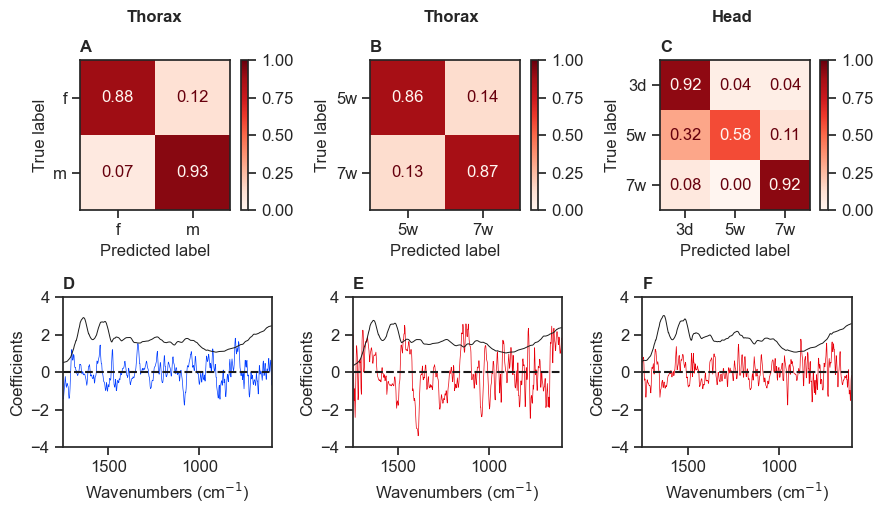

In [127]:
# plot Fig S3
# Final plot paper
# confusion matrix for head and model coefficients

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )
fig, ((ax, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(9,5), tight_layout=False)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_sex_thorax_pred,display_labels=loaded_model_sex_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_sex_thorax['model'].coef_[0], color='b',ax=ax4, linewidth=0.5)

sn.lineplot(x=wavenumbers, y=(np.mean(X_sex_thorax ,axis=0)*10),color='k',ax=ax4, linewidth=0.7)

#ax4.set_ylim(-3,4)


# males
disp = ConfusionMatrixDisplay.from_predictions(ym_th_test,y_male_thorax_pred,display_labels=loaded_model_males_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_males_thorax['model'].coef_[0], color='r',ax=ax5, linewidth=0.5)
sn.lineplot(x=wavenumbers, y=(np.mean(X_males_thorax ,axis=0)*10),color='k',ax=ax5, linewidth=0.7)


# females
disp = ConfusionMatrixDisplay.from_predictions(yf_hd_test,y_female_head_pred,display_labels=loaded_model_females_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax3, im_kw={'vmin':0, 'vmax':1})

sn.lineplot(x=wavenumbers,y=loaded_model_females_head['model'].coef_[0], color='r',ax=ax6, linewidth=0.5)
sn.lineplot(x=wavenumbers, y=(np.mean(X_females_head ,axis=0)*10),color='k',ax=ax6, linewidth=0.7)

plots = [ax4,ax5,ax6]
for i in plots:
    i.set_xlim(1750,600)
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")
    i.set_ylabel("Coefficients")
    i.axhline(0, ls="--",color='k')
    i.set_ylim(-4,4)

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")

fig.text(x=0.15,y=1,s="Thorax",fontweight='bold')
fig.text(x=0.48,y=1,s="Thorax",fontweight='bold')
fig.text(x=0.8,y=1,s="Head",fontweight='bold')

plt.savefig("../results/plots/FigS3.tiff", dpi=300,bbox_inches='tight')



In [34]:
variable_importance_sex_head = variable_importance_df(wavenumbers, loaded_model_sex_head)
variable_importance_males_head = variable_importance_df(wavenumbers,loaded_model_males_head)
variable_importance_females_head = variable_importance_df(wavenumbers, loaded_model_females_head)

In [35]:
variable_importance_sex_thorax = variable_importance_df(wavenumbers, loaded_model_sex_thorax)
variable_importance_males_thorax = variable_importance_df(wavenumbers,loaded_model_males_thorax)
variable_importance_females_thorax = variable_importance_df(wavenumbers, loaded_model_females_thorax)

Text(0.4, 0, 'Wavenumbers (cm-1)')

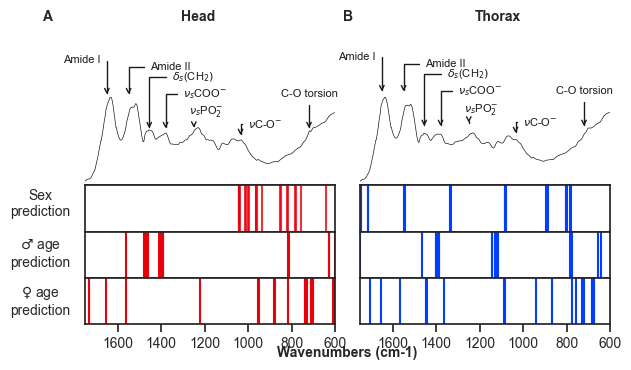

In [628]:
fig = plt.figure(layout=None,figsize=(7.5,3))
gs = fig.add_gridspec(nrows=5, ncols=2, left=0.05, right=0.75,
                      hspace=0, wspace=0.1)
ax0 = fig.add_subplot(gs[0:2, 0])
#ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])
ax4 = fig.add_subplot(gs[4,0])


ax5 = fig.add_subplot(gs[0:2, 1])
#ax1 = fig.add_subplot(gs[1,0])
ax6 = fig.add_subplot(gs[2,1])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,1])

ax0.plot(wavenumbers,np.mean(tsetse_head.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)

ax5.plot(wavenumbers,np.mean(tsetse_thorax.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)

for i in variable_importance_sex_head["Wavenumbers"]:
    ax2.axvline(i,color="r",alpha=0.8)

for i in variable_importance_males_head["Wavenumbers"]:
    ax3.axvline(i,color="r")

for i in variable_importance_females_head["Wavenumbers"]:
    ax4.axvline(i, color="r")

for i in [ax0,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    i.set_xlim(1750, 600)
    i.tick_params(left = False, right = False , labelleft = False)


for s in [ax0,ax5]:
    s.spines.right.set_visible(False)
    s.spines.top.set_visible(False)
    s.spines.left.set_visible(False)
    s.tick_params(bottom = False, labelbottom=False,labelleft=False)

for a in [ax2,ax3,ax6,ax7]:
    a.tick_params(bottom = False, labelbottom=False)
    a.tick_params(bottom = False, labelbottom=False)


fig.text(x=-0.01,y=0.47, s='Sex\nprediction', horizontalalignment='center')
fig.text(x=-0.01,y=0.3, s='$\u2642$ age\nprediction', horizontalalignment='center')
fig.text(x=-0.01,y=0.14, s='$\u2640$ age\nprediction', horizontalalignment='center')



for i in variable_importance_sex_thorax["Wavenumbers"]:
    ax6.axvline(i,color="b")

for i in variable_importance_males_thorax["Wavenumbers"]:
    ax7.axvline(i,color="b")

for i in variable_importance_females_thorax["Wavenumbers"]:
    ax8.axvline(i,color="b")


fontsize2=8
arrowprops2 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=0",color='k',lw=1)

for i in [ax0,ax5]:
    i.annotate('Amide I',(1650, 0.3), xytext=(1850, 0.4), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('Amide II',(1550, 0.3), xytext=(1450, 0.38), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('$\delta{_s}$(CH$_{2})$',(1455, 0.2), xytext=(1350, 0.35), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate(r'$\nu$${_s}$COO$^{-}$',(1380, 0.2), xytext=(1300, 0.3), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate(r'$\nu$${_s}$PO$_{2}^{-}$',(1250, 0.21), xytext=(1270, 0.25), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate(r'$\nu$C-O$^{-}$',(1035, 0.18), xytext=(1000, 0.21), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")

    #i.annotate('-($CH_2$)-rock',
    #        xy=(800,0.2), xytext=(950, 0.3),xycoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('C-O torsion',
            xy=(720,0.2), xytext=(850, 0.3), xycoords='data',fontsize=fontsize2,color='k',arrowprops=arrowprops2)

fig.text(x=0.2,y=1.12, s='Head', horizontalalignment='center',fontweight='bold')
fig.text(x=0.6,y=1.12, s='Thorax', horizontalalignment='center',fontweight='bold')

fig.text(x=0,y=1.12, s='A', horizontalalignment='center',fontweight='bold')
fig.text(x=0.4,y=1.12, s='B', horizontalalignment='center',fontweight='bold')
fig.text(x=0.4,y=0, s='Wavenumbers (cm-1)', horizontalalignment='center',fontweight='bold')


Text(950, 0.2, '$\\nu$C-O$^{-}$')

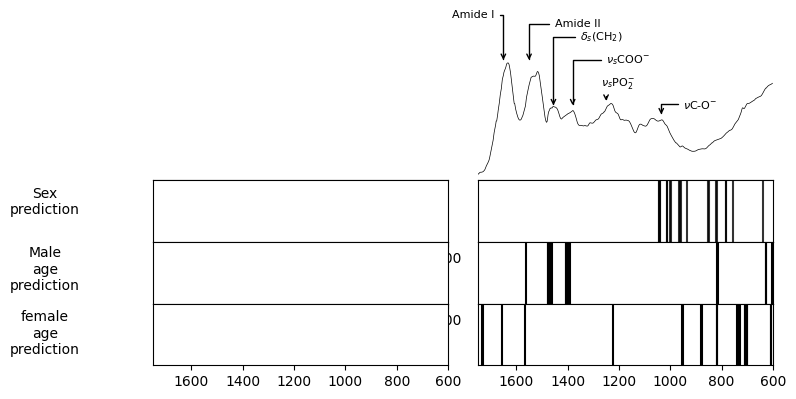

In [412]:

fig = plt.figure(layout=None,figsize=(8,4))
gs = fig.add_gridspec(nrows=5, ncols=2,
                      hspace=0, wspace=0.1)
ax0 = fig.add_subplot(gs[0:2, 1])
#ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,1])
ax3 = fig.add_subplot(gs[3,1])
ax4 = fig.add_subplot(gs[4,1])


ax5 = fig.add_subplot(gs[0:2, 0])
#ax1 = fig.add_subplot(gs[1,0])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax8 = fig.add_subplot(gs[4,0])

ax0.plot(wavenumbers,np.mean(tsetse_head.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)


for i in variable_importance_sex_head["Wavenumbers"]:
    ax2.axvline(i,color="k",alpha=0.8)

for i in variable_importance_males_head["Wavenumbers"]:
    ax3.axvline(i,color="k")

for i in variable_importance_females_head["Wavenumbers"]:
    ax4.axvline(i, color="k")

for i in [ax0,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    i.set_xlim(1750, 600)
    i.tick_params(left = False, right = False , labelleft = False)


for s in [ax0,ax5]:
    s.spines.right.set_visible(False)
    s.spines.top.set_visible(False)
    s.spines.left.set_visible(False)
    s.tick_params(bottom = False, labelbottom=False,labelleft=False)

ax2.tick_params(bottom = False, labelbottom=False)
ax3.tick_params(bottom = False, labelbottom=False)





fig.text(x=-0.01,y=0.49, s='Sex\nprediction', horizontalalignment='center')
fig.text(x=-0.01,y=0.3, s='Male\nage\nprediction', horizontalalignment='center')
fig.text(x=-0.01,y=0.14, s='female\nage\nprediction', horizontalalignment='center')



fontsize2=8
arrowprops2 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=0",color='k',lw=1)

ax0.annotate('Amide I',(1650, 0.3), xytext=(1850, 0.4), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax0.annotate('Amide II',(1550, 0.3), xytext=(1450, 0.38), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax0.annotate('$\delta{_s}$(CH$_{2})$',(1455, 0.2), xytext=(1350, 0.35), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax0.annotate(r'$\nu$${_s}$COO$^{-}$',(1380, 0.2), xytext=(1250, 0.3), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax0.annotate(r'$\nu$${_s}$PO$_{2}^{-}$',(1250, 0.21), xytext=(1270, 0.25), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax0.annotate(r'$\nu$C-O$^{-}$',(1035, 0.18), xytext=(950, 0.2), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")

#disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_sex_head_pred,#display_labels=loaded_model_sex_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5, colorbar=False)

Text(0.5, 1, 'B')

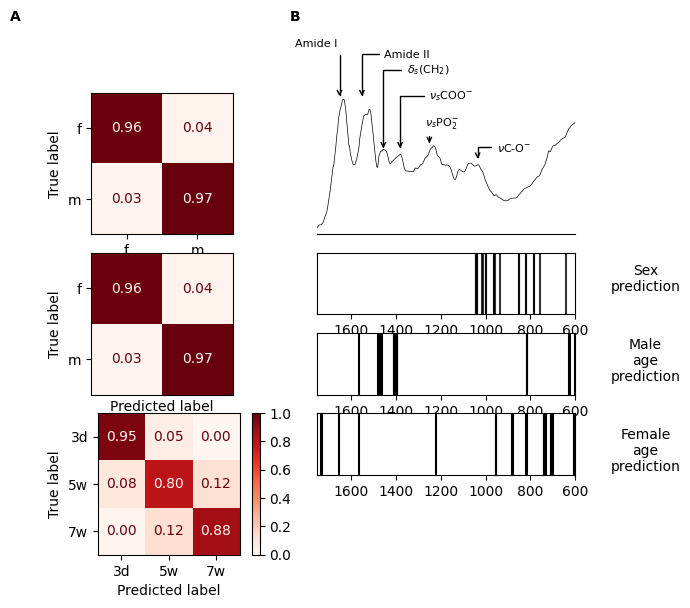

In [463]:
fig = plt.figure(layout=None,figsize=(7,6))
gs = fig.add_gridspec(nrows=6, ncols=2,
                      hspace=0.3, wspace=0.1)
ax0 = fig.add_subplot(gs[0:2,0])
ax2 = fig.add_subplot(gs[2:4,0])
ax3 = fig.add_subplot(gs[4:6,0])

ax4 = fig.add_subplot(gs[0:2,1])
#ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[2,1])
ax7 = fig.add_subplot(gs[3,1])
ax8 = fig.add_subplot(gs[4,1])

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_sex_head_pred,display_labels=loaded_model_sex_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax0, colorbar=False)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_sex_head_pred,display_labels=loaded_model_sex_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, colorbar=False)

disp = ConfusionMatrixDisplay.from_predictions(yf_th_test,y_female_thorax_pred,display_labels=loaded_model_females_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax3, im_kw={'vmin':0, 'vmax':1})

ax4.plot(wavenumbers,np.mean(tsetse_head.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)

for i in variable_importance_sex_head["Wavenumbers"]:
    ax6.axvline(i,color="k",alpha=0.8)

for i in variable_importance_males_head["Wavenumbers"]:
    ax7.axvline(i,color="k")

for i in variable_importance_females_head["Wavenumbers"]:
    ax8.axvline(i, color="k")


ax4.spines.right.set_visible(False)
ax4.spines.top.set_visible(False)
ax4.spines.left.set_visible(False)
ax4.tick_params(bottom = False, labelbottom=False,labelleft=False)

for i in [ax4,ax5,ax6,ax7,ax8]:
    i.set_xlim(1750, 600)
    i.tick_params(left = False, right = False , labelleft = False)

ax2.tick_params(bottom = False, labelbottom=False)
#ax3.tick_params(bottom = False, labelbottom=False)

fontsize2=8
arrowprops2 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=0",color='k',lw=1)

ax4.annotate('Amide I',(1650, 0.3), xytext=(1850, 0.4), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax4.annotate('Amide II',(1550, 0.3), xytext=(1450, 0.38), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax4.annotate('$\delta{_s}$(CH$_{2})$',(1455, 0.2), xytext=(1350, 0.35), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax4.annotate(r'$\nu$${_s}$COO$^{-}$',(1380, 0.2), xytext=(1250, 0.3), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax4.annotate(r'$\nu$${_s}$PO$_{2}^{-}$',(1250, 0.21), xytext=(1270, 0.25), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax4.annotate(r'$\nu$C-O$^{-}$',(1035, 0.18), xytext=(950, 0.2), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")

fig.text(x=1,y=0.55, s='Sex\nprediction', horizontalalignment='center')
fig.text(x=1,y=0.4, s='Male\nage\nprediction', horizontalalignment='center')
fig.text(x=1,y=0.25, s='Female\nage\nprediction', horizontalalignment='center')


fig.text(x=0.1,y=1, s='A', horizontalalignment='center', fontweight='bold')
fig.text(x=0.5,y=1, s='B', horizontalalignment='center', fontweight='bold')


Text(0.95, 0.56, '$♀$ age')

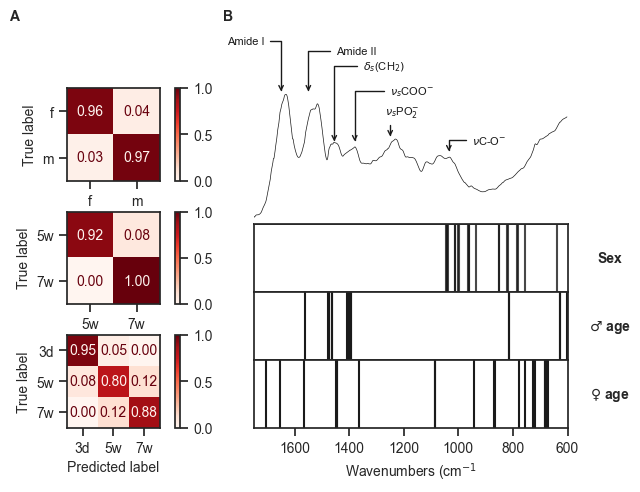

In [588]:
rc={'font.size': 10,
    "font.family":"Arial",
    "axes.labelsize":10,
    'xtick.labelsize':10,
    'ytick.labelsize':10}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )


import matplotlib.gridspec as gridspec
#f = plt.figure(figsize=(7.5,8.7))
f = plt.figure(figsize=(8.5,9.7))
gs0 = gridspec.GridSpec(2, 2,wspace=0.1)
gs00 = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[1], hspace=0)
ax0 = f.add_subplot(gs00[2])
ax1 = f.add_subplot(gs00[3], sharex=ax0)
ax2 = f.add_subplot(gs00[4],sharex=ax0)

ax3 = f.add_subplot(gs00[0:2])

for i in variable_importance_sex_head["Wavenumbers"]:
    ax0.axvline(i,color="k",alpha=0.8)

for i in variable_importance_males_head["Wavenumbers"]:
    ax1.axvline(i,color="k")

for i in variable_importance_females_thorax["Wavenumbers"]:
    ax2.axvline(i, color="k")

ax3.plot(wavenumbers,np.mean(tsetse_head.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)

gs01 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[0], hspace=1)

ax5 = f.add_subplot(gs01[0:2])
disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_sex_head_pred,display_labels=loaded_model_sex_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5, colorbar=True,im_kw={'vmin':0, 'vmax':1})
ax5.set_xlabel('')

ax6 = f.add_subplot(gs01[2:4])
disp = ConfusionMatrixDisplay.from_predictions(ym_hd_test,y_male_head_pred,display_labels=loaded_model_males_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax6, im_kw={'vmin':0, 'vmax':1})
ax6.set_xlabel('')

ax7 = f.add_subplot(gs01[4:6])
disp = ConfusionMatrixDisplay.from_predictions(yf_th_test,y_female_thorax_pred,display_labels=loaded_model_females_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax7, im_kw={'vmin':0, 'vmax':1})



fontsize2=8
arrowprops2 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=0",color='k',lw=1)

ax3.annotate('Amide I',(1650, 0.3), xytext=(1850, 0.4), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate('Amide II',(1550, 0.3), xytext=(1450, 0.38), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate('$\delta{_s}$(CH$_{2})$',(1455, 0.2), xytext=(1350, 0.35), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate(r'$\nu$${_s}$COO$^{-}$',(1380, 0.2), xytext=(1250, 0.3), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate(r'$\nu$${_s}$PO$_{2}^{-}$',(1250, 0.21), xytext=(1270, 0.26), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate(r'$\nu$C-O$^{-}$',(1035, 0.18), xytext=(950, 0.2), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")

for i in [ax0,ax1,ax2,ax3]:
    i.set_xlim(1750,600)

ax2.set_xlabel("Wavenumbers (cm$^{-1}$")


ax3.spines.right.set_visible(False)
ax3.spines.top.set_visible(False)
ax3.spines.left.set_visible(False)
ax3.tick_params(bottom = False, labelbottom=False,labelleft=False, left=False)

ax0.tick_params(bottom = False, labelbottom=False, labelleft=False, left=False )
ax1.tick_params(bottom = False, labelbottom=False, labelleft=False, left=False )
ax2.tick_params(labelleft=False, left=False )

f.text(x=0.25,y=0.95, s='A', horizontalalignment='center', fontweight='bold')
f.text(x=0.5,y=0.95, s='B', horizontalalignment='center', fontweight='bold')

f.text(x=0.95,y=0.7, s='Sex', horizontalalignment='center',fontweight='bold')
f.text(x=0.95,y=0.63, s='$\u2642$ age', horizontalalignment='center',fontweight='bold')
f.text(x=0.95,y=0.56, s='$\u2640$ age', horizontalalignment='center',fontweight='bold')
    

Text(0.95, 0.56, '$♀$ age')

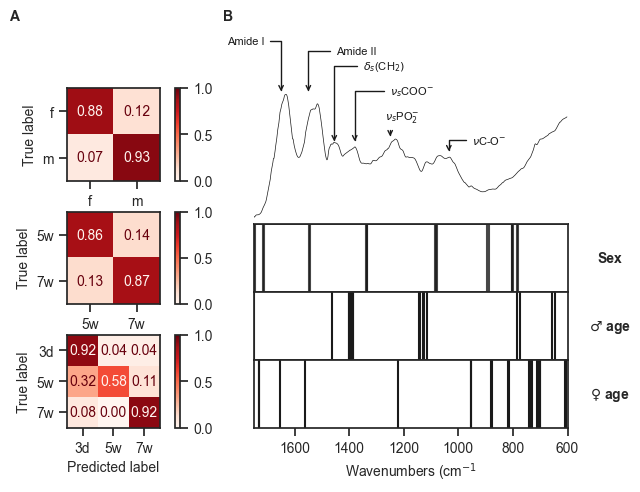

In [585]:
rc={'font.size': 10,
    "font.family":"Arial",
    "axes.labelsize":10,
    'xtick.labelsize':10,
    'ytick.labelsize':10}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )


import matplotlib.gridspec as gridspec
#f = plt.figure(figsize=(7.5,8.7))
f = plt.figure(figsize=(8.5,9.7))
gs0 = gridspec.GridSpec(2, 2,wspace=0.1)
gs00 = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[1], hspace=0)
ax0 = f.add_subplot(gs00[2])
ax1 = f.add_subplot(gs00[3], sharex=ax0)
ax2 = f.add_subplot(gs00[4],sharex=ax0)

ax3 = f.add_subplot(gs00[0:2])

for i in variable_importance_sex_thorax["Wavenumbers"]:
    ax0.axvline(i,color="k",alpha=0.8)

for i in variable_importance_males_thorax["Wavenumbers"]:
    ax1.axvline(i,color="k")

for i in variable_importance_females_head["Wavenumbers"]:
    ax2.axvline(i, color="k")

ax3.plot(wavenumbers,np.mean(tsetse_head.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)

gs01 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[0], hspace=1)

ax5 = f.add_subplot(gs01[0:2])
disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_sex_thorax_pred,display_labels=loaded_model_sex_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5,colorbar=True,im_kw={'vmin':0, 'vmax':1})
ax5.set_xlabel('')

ax6 = f.add_subplot(gs01[2:4])
disp = ConfusionMatrixDisplay.from_predictions(ym_th_test,y_male_thorax_pred,display_labels=loaded_model_males_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax6, im_kw={'vmin':0, 'vmax':1},colorbar=True)
ax6.set_xlabel('')

ax7 = f.add_subplot(gs01[4:6])
disp = ConfusionMatrixDisplay.from_predictions(yf_hd_test,y_female_head_pred,display_labels=loaded_model_females_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax7, im_kw={'vmin':0, 'vmax':1},colorbar=True)



fontsize2=8
arrowprops2 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=0",color='k',lw=1)

ax3.annotate('Amide I',(1650, 0.3), xytext=(1850, 0.4), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate('Amide II',(1550, 0.3), xytext=(1450, 0.38), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate('$\delta{_s}$(CH$_{2})$',(1455, 0.2), xytext=(1350, 0.35), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate(r'$\nu$${_s}$COO$^{-}$',(1380, 0.2), xytext=(1250, 0.3), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate(r'$\nu$${_s}$PO$_{2}^{-}$',(1250, 0.21), xytext=(1270, 0.25), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

ax3.annotate(r'$\nu$C-O$^{-}$',(1035, 0.18), xytext=(950, 0.2), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")

for i in [ax0,ax1,ax2,ax3]:
    i.set_xlim(1750,600)

ax2.set_xlabel("Wavenumbers (cm$^{-1}$")


ax3.spines.right.set_visible(False)
ax3.spines.top.set_visible(False)
ax3.spines.left.set_visible(False)
ax3.tick_params(bottom = False, labelbottom=False,labelleft=False, left=False)

ax0.tick_params(bottom = False, labelbottom=False, labelleft=False, left=False )
ax1.tick_params(bottom = False, labelbottom=False, labelleft=False, left=False )
ax2.tick_params(labelleft=False, left=False )

f.text(x=0.25,y=0.95, s='A', horizontalalignment='center', fontweight='bold')
f.text(x=0.5,y=0.95, s='B', horizontalalignment='center', fontweight='bold')

f.text(x=0.95,y=0.7, s='Sex', horizontalalignment='center',fontweight='bold')
f.text(x=0.95,y=0.63, s='$\u2642$ age', horizontalalignment='center',fontweight='bold')
f.text(x=0.95,y=0.56, s='$\u2640$ age', horizontalalignment='center',fontweight='bold')

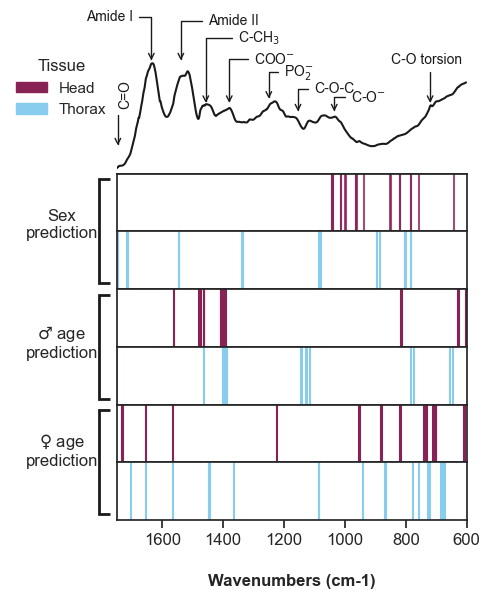

In [835]:
import matplotlib.patches as mpatches

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )

color1 = "#88CCEE"

color2 = "#882255"
fig = plt.figure(layout=None,figsize=(5,6))
gs = fig.add_gridspec(nrows=8, ncols=1, left=0.05, right=0.75,
                      hspace=0, wspace=0.1)
ax0 = fig.add_subplot(gs[0:2, 0])
#ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])
ax4 = fig.add_subplot(gs[4,0])


ax6 = fig.add_subplot(gs[5,0])
ax7 = fig.add_subplot(gs[6,0])
ax8 = fig.add_subplot(gs[7,0])

ax0.plot(wavenumbers,np.mean(tsetse_head.loc[:,"1750":"602"],axis=0),color='k', linewidth=1.5)

ax5.plot(wavenumbers,np.mean(tsetse_thorax.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)

for i in variable_importance_sex_head["Wavenumbers"]:
    ax2.axvline(i,color=color2,alpha=0.8)

for i in variable_importance_sex_thorax["Wavenumbers"]:
    ax3.axvline(i,color=color1)

for i in variable_importance_males_head["Wavenumbers"]:
    ax4.axvline(i, color=color2)

for i in [ax0,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    i.set_xlim(1750, 600)
    i.tick_params(left = False, right = False , labelleft = False)


for s in [ax0,ax5]:
    s.spines.right.set_visible(False)
    s.spines.top.set_visible(False)
    s.spines.left.set_visible(False)
    s.tick_params(bottom = False, labelbottom=False,labelleft=False)

for a in [ax2,ax3,ax4,ax6,ax7]:
    a.tick_params(bottom = False, labelbottom=False)
    a.tick_params(bottom = False, labelbottom=False)


for i in variable_importance_males_thorax["Wavenumbers"]:
    ax6.axvline(i,color=color1)

for i in variable_importance_females_head["Wavenumbers"]:
    ax7.axvline(i,color=color2)

for i in variable_importance_females_thorax["Wavenumbers"]:
    ax8.axvline(i,color=color1)


fontsize2=10
arrowprops2 = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=0",color='k',lw=1)

for i in [ax0,ax5]:
    i.annotate('Amide I',(1636, 0.3), xytext=(1850, 0.4), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('Amide II',(1539, 0.3), xytext=(1450, 0.39), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('C-CH$_{3}$',(1457, 0.2), xytext=(1350, 0.35), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('COO$^{-}$',(1380, 0.2), xytext=(1300, 0.3), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    #i.annotate('C-N',(1307, 0.2), xytext=(1300, 0.3), textcoords='data',#arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('PO$_{2}^{-}$',(1250, 0.21), xytext=(1200, 0.27), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('C-O-C',(1154, 0.18), xytext=(1100, 0.23), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")


    i.annotate('C-O$^{-}$',(1035, 0.18), xytext=(980, 0.21), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k")


    i.annotate('C=O',(1746, 0.1), xytext=(1746, 0.2), textcoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color="k",rotation=90)

    #i.annotate('-($CH_2$)-rock',
    #        xy=(800,0.2), xytext=(950, 0.3),xycoords='data',arrowprops=arrowprops2,fontsize=fontsize2,color='k')

    i.annotate('C-O torsion',
            xy=(720,0.2), xytext=(850, 0.3), xycoords='data',fontsize=fontsize2,color='k',arrowprops=arrowprops2)


fig.text(x=0.4,y=0, s='Wavenumbers (cm-1)', horizontalalignment='center',fontweight='bold')

fig.text(x=-0.06,y=0.58, s='Sex\nprediction', horizontalalignment='center')
fig.text(x=-0.06,y=0.38, s='$\u2642$ age\nprediction', horizontalalignment='center')
fig.text(x=-0.06,y=0.2, s='$\u2640$ age\nprediction', horizontalalignment='center')

add_label_band(ax2, -0.9, 0.9, "")
add_label_band(ax4, -0.9, 0.9, "")
add_label_band(ax7, -0.9, 0.9, "")

# legend
head_patch = mpatches.Patch(color=color2, label='Head')
thorax_patch = mpatches.Patch(color=color1, label='Thorax')
plt.legend(handles=[head_patch,thorax_patch],title='Tissue',bbox_to_anchor=(0.01, 8.225),edgecolor='None')

plt.savefig('../results/plots/Fignew.png', dpi=300,bbox_inches="tight")

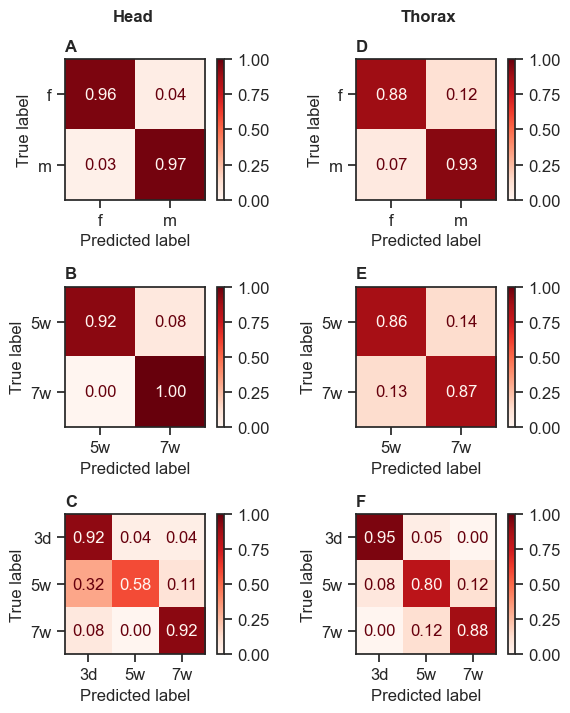

In [70]:

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )

fig, ((ax, ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2, figsize=(6,7),layout='tight')

y_list = [y_hd_test,ym_hd_test,yf_hd_test,y_th_test,ym_th_test,yf_th_test]
y_pred_list = [y_sex_head_pred,y_male_head_pred,y_female_head_pred,y_sex_thorax_pred,y_male_thorax_pred,y_female_thorax_pred]
models_list = [loaded_model_sex_head.classes_,loaded_model_males_head.classes_,loaded_model_females_head.classes_,loaded_model_sex_thorax.classes_,loaded_model_males_thorax.classes_,loaded_model_females_thorax.classes_]
axes_list = [ax,ax2,ax3,ax4,ax5,ax6]

cmap_color=plt.cm.Reds

for a, b, c, d in zip(y_list, y_pred_list, models_list,axes_list):
    disp = ConfusionMatrixDisplay.from_predictions(a,b,display_labels=c, normalize='true', values_format='.2f', cmap=cmap_color, ax=d,colorbar=True,im_kw={'vmin':0, 'vmax':1})

label_list =["A", "B", "C", "D", "E", "F", "G"]

for i,t in zip(axes_list, label_list):
    i.set_title(t, loc='left', fontweight='bold', fontsize=12)

fig.text(x=0.22,y=1,s="Head", fontweight="bold")
fig.text(x=0.7,y=1,s="Thorax", fontweight="bold")

plt.savefig("../results/plots/Fig5.png", dpi=300, bbox_inches='tight')





In [42]:
variable_importance_females_thorax

,Wavenumbers,Coefficients
332,1086,4.339547
487,776,4.313731
333,1084,4.299688
152,1446,4.295545
151,1448,4.046918
153,1444,3.949382
534,682,3.858901
404,942,3.857604
533,684,3.792633
92,1566,3.759834


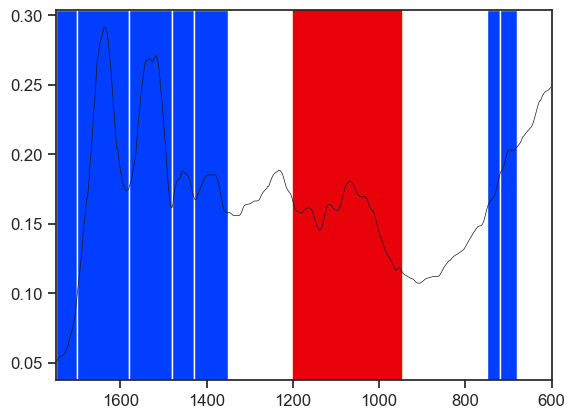

In [68]:
fig, ax = plt.subplots()
ax.plot(wavenumbers,np.mean(tsetse_thorax.loc[:,"1750":"602"],axis=0),color='k', linewidth=0.5)
ax.set_xlim(1750,600)


ax.axvspan(1200,950,color='r') #C-O stretch
ax.axvspan(750,720) #-ch2-rock
ax.axvspan(720,680) # C-O torsion

ax.axvspan(1750,1700)# C=O proteins, waxes, lipids
ax.axvspan(1700,1580) # Amide I
ax.axvspan(1580,1480) # Amide II
ax.axvspan(1480, 1430) # C-H wax  lipdis
ax.axvspan(1430, 1350) # C-H wax proteins


In [80]:
mc_male_head_acc,mc_male_head_sens,mc_male_head_spec = montecarlo_crossvalidation(X_males_head,y_males_head,males_best_model_head,binary=True)

shuffle split: 100%|██████████| 500/500 [00:12<00:00, 39.64it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.83 ± 0.06


In [83]:
mc_sex_head_acc,mc_sex_head_sens,mc_sex_head_spec = montecarlo_crossvalidation(X_sex_head,y_sex_head,best_model_head,binary=True)

shuffle split:   0%|          | 0/500 [00:00<?, ?it/s]

shuffle split: 100%|██████████| 500/500 [00:54<00:00,  9.14it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.96 ± 0.02
